## Hypothesis: High number of pregnancies cause a higher risk of diabetes at greater age

DV: diabetes
IV: pregnancies, age

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import stan
import csv

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train, test = train_test_split(df, test_size=0.5)

In [2]:
import nest_asyncio #this library is important to use pystan

nest_asyncio.apply()

In [3]:
import scipy.stats as stats

In [4]:
## import data

df = pd.read_csv('../db/diabetes.csv')

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [61]:
## normal distribution

stan_code = """

data {
int<lower=0> N;
vector[N] y;
vector[N] pregnancies;
vector[N] ages;
}

parameters {
real alpha;
real beta_preg;
real beta_age;
real <lower=0> sigma;
}

model {
//prior 
alpha ~ normal(0,10);
beta_preg ~ normal(0,10);
beta_age~ normal(0,10);
sigma ~ cauchy(0,5);

//model
y ~ normal(pregnancies * beta_preg + ages * beta_age + alpha, sigma);
}

generated quantities {
//predictive posterior check

vector[N] y_rep;

for(n in 1:N){

y_rep[n] = normal_rng(pregnancies[n] * beta_preg + ages[n] * beta_age + alpha, sigma);

}
}
"""

In [14]:
data = {
"N": len(df), 
"pregnancies": df.loc[:, "Pregnancies"].values,
"ages": df.loc[:, "Age"].values,
 "y": df.loc[:, "DiabetesPedigreeFunction"].values,   
}

In [9]:
stan_model = stan.build(stan_code, data=data)

Building: found in cache, done.


In [10]:
fit = stan_model.sample(num_chains=4, num_samples=1000, num_warmup=500) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   5% (300/6000)
Sampling:   8% (500/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  37% (2200/6000)
Sampling:  57% (3400/6000)
Sampling:  78% (4700/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000215 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000253 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000212 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000173 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.73 seconds

In [11]:
stan_data_simu_v1 = az.from_pystan(
    posterior=fit,
    posterior_predictive="y_rep",
    observed_data=["y"],
    posterior_model=stan_model,
    coords={"y_hat": np.arange(data["N"])},
)

<Axes: xlabel='y / y_rep'>

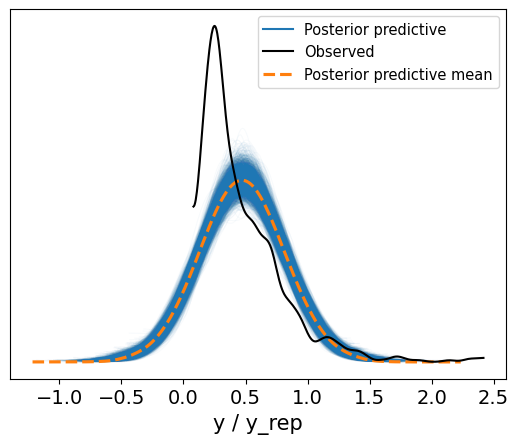

In [12]:
az.plot_ppc(stan_data_simu_v1, data_pairs={"y": "y_rep"}, alpha=0.03, textsize=14)

In [14]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_preg,beta_age,...,y_rep.759,y_rep.760,y_rep.761,y_rep.762,y_rep.763,y_rep.764,y_rep.765,y_rep.766,y_rep.767,y_rep.768
draws,,,,,,,,,,,,,,,,,,,,,
0,464.837763,0.995119,0.066644,5.0,63.0,0.0,-462.150252,0.453553,-0.003580,0.000860,...,1.049656,1.104253,0.721745,0.642772,0.370960,0.397650,0.574589,0.011683,0.357025,0.592102
1,461.343034,0.768189,0.069180,5.0,31.0,0.0,-458.680677,0.446448,0.004272,0.000512,...,0.486456,0.687251,-0.125121,0.821223,0.267616,0.413777,0.711396,0.334976,1.094373,0.280526
2,465.536911,0.994728,0.062838,4.0,31.0,0.0,-464.053402,0.432371,-0.007333,0.001885,...,0.536456,0.178046,0.725885,0.538305,0.018368,0.929052,0.673966,-0.128554,0.235795,0.113531
3,465.144610,0.899032,0.069474,3.0,11.0,0.0,-464.267755,0.443725,-0.005031,0.001590,...,0.980122,0.673435,0.625986,0.340780,0.315535,0.951798,0.399818,1.194363,0.836604,0.844481
4,465.418777,0.918460,0.066644,5.0,31.0,0.0,-464.086815,0.430321,-0.005099,0.001698,...,0.344342,0.170448,0.283676,0.458649,0.549975,0.353633,0.481844,0.893877,1.066624,0.248482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,460.134553,0.912748,0.069474,6.0,63.0,0.0,-457.638862,0.322684,-0.004979,0.005062,...,0.433524,0.850508,0.186996,0.587730,0.445283,0.690821,0.360177,0.396368,0.057350,0.423864
3996,463.593753,0.890680,0.066644,6.0,63.0,0.0,-461.549141,0.375509,-0.008133,0.004108,...,0.381062,0.490785,0.771616,0.343117,0.391249,0.326564,0.437016,0.355922,1.424258,0.757594
3997,463.744152,0.992900,0.069180,6.0,63.0,0.0,-461.213174,0.470200,-0.000859,0.000552,...,0.186298,0.190030,0.655357,0.313235,0.950848,0.729237,0.397777,-0.098379,0.793580,0.534667


<Axes: >

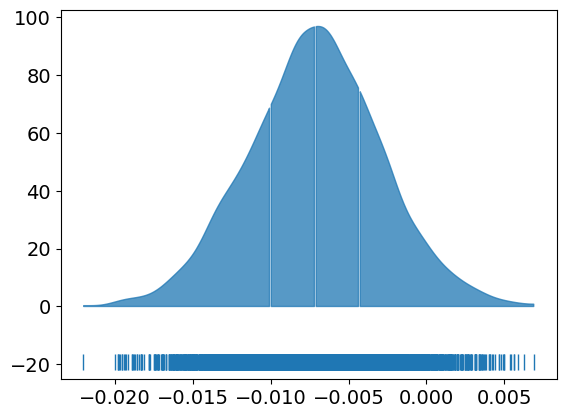

In [16]:
az.plot_dist(fit['beta_preg'], rug=True, quantiles=[.25, .5, .75])

<Axes: >

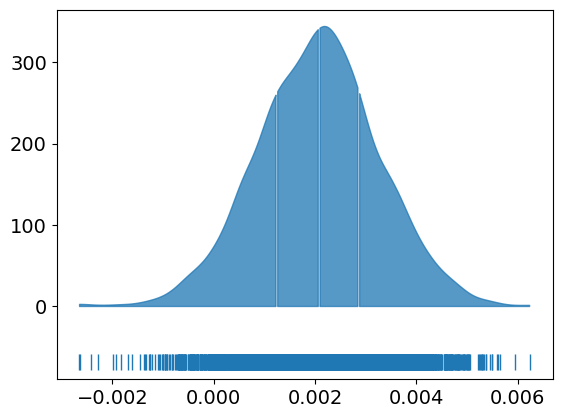

In [17]:
az.plot_dist(fit['beta_age'], rug=True, quantiles=[.25, .5, .75])

<Axes: >

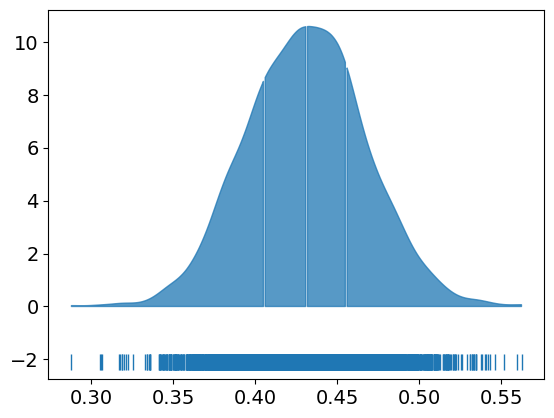

In [18]:
az.plot_dist(fit['alpha'], rug=True, quantiles=[.25, .5, .75])

Picking 1,000 values from updated distribution (posterior distribution). Picking 1,000, four times.
Draws 1 data means what has been sampled after being MCMC sampling.

In [19]:
summary1 = az.summary(fit) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [20]:
summary1

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.431,0.036,0.364,0.499,0.001,0.001,1958.0,1865.0,1.0
beta_preg,-0.007,0.004,-0.015,0.001,0.000,0.000,3081.0,2040.0,1.0
beta_age,0.002,0.001,-0.000,0.004,0.000,0.000,2197.0,2009.0,1.0
sigma,0.331,0.009,0.316,0.347,0.000,0.000,1717.0,1755.0,1.0
y_rep[0],0.475,0.333,-0.158,1.082,0.005,0.004,4162.0,3890.0,1.0
...,...,...,...,...,...,...,...,...,...
y_rep[763],0.493,0.334,-0.136,1.123,0.006,0.004,3485.0,3581.0,1.0
y_rep[764],0.477,0.327,-0.107,1.114,0.005,0.004,3932.0,3922.0,1.0
y_rep[765],0.461,0.337,-0.181,1.089,0.005,0.004,3875.0,3845.0,1.0
y_rep[766],0.515,0.334,-0.127,1.126,0.005,0.004,4430.0,4057.0,1.0


<Axes: >

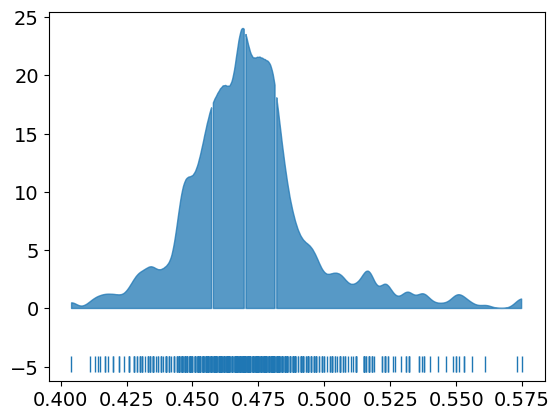

In [21]:
az.plot_dist(summary1['mean'][5:], rug=True, quantiles=[.25, .5, .75])

### second iteration

apply log_normalization to beta_preg distribution 

In [33]:
stan_code_v2 = """

data {
int<lower=0> N;
vector[N] y;
vector[N] pregnancies;
vector[N] ages;
}

parameters {
real alpha;
real beta_preg;
real beta_age;
real <lower=0> sigma;
}

model {
//prior 
alpha ~ normal(0.46,1);
beta_preg ~ lognormal(0,1);
beta_age~ normal(0,1);
sigma ~ cauchy(0,5);

//model
y ~ normal(pregnancies * beta_preg + ages * beta_age + alpha, sigma);
}

generated quantities {
//predictive posterior check

vector[N] y_rep;

for(n in 1:N){

y_rep[n] = normal_rng(pregnancies[n] * beta_preg + ages[n] * beta_age + alpha, sigma);

}
}
"""

In [40]:
stan_model_v2 = stan.build(stan_code_v2, data=data)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/7j4m5jdt/model_7j4m5jdt.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-pac

Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/7j4m5jdt/model_7j4m5jdt.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 3.6s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/7j4m5jdt/model_7j4m5jdt.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/7j4m5jdt/model_7j4m5jdt.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:12:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp:468:7: warning: unused variable 'kdiv' [-Wunused-variable]
  int kdiv = kdivide;
      ^


Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/7j4m5jdt/model_7j4m5jdt.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:15:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-

Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/7j4m5jdt/model_7j4m5jdt.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused variable 'n' [-Wunused-variable]
  int n = G.rows();  // number of states
      ^


Building: 7.1s
Building: 7.3s
Building: 7.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/7j4m5jdt/model_7j4m5jdt.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan

Building: 7.5s
Building: 7.6s
Building: 7.7s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/7j4m5jdt/model_7j4m5jdt.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan

Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/7j4m5jdt/model_7j4m5jdt.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s


/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/7j4m5jdt/model_7j4m5jdt.cpp:2:
In file i

Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/7j4m5jdt/model_7j4m5jdt.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:100:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                                ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/h

Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s


21 warnings generated.


ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being linked (10.9)ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)

ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_cvodes.a(cvodea.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: ob

In [41]:
fit2 = stan_model_v2.sample(num_chains=4, num_samples=1000, num_warmup=500) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   3% (201/6000)
Sampling:   7% (401/6000)
Sampling:   8% (501/6000)
Sampling:  10% (601/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  40% (2400/6000)
Sampling:  60% (3600/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: lognormal_lpdf: Random variable is -0.124116, but must be nonnegative! (in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_h9ag6jcu/model_7j4m5jdt.stan', line 20, column 0 to column 27)
  Gradient evaluation took 0.002217 seconds
  1000 transitions using 10 leapfrog steps per transition would take 22.17 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejecte

In [42]:
fit2.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_preg,beta_age,...,y_rep.759,y_rep.760,y_rep.761,y_rep.762,y_rep.763,y_rep.764,y_rep.765,y_rep.766,y_rep.767,y_rep.768
draws,,,,,,,,,,,,,,,,,,,,,
0,451.144680,0.995463,0.071212,5.0,31.0,0.0,-450.576528,0.458879,0.004018,-0.000007,...,0.413765,0.597371,0.679421,0.185459,0.065721,0.273422,0.293893,0.564905,0.285954,0.337270
1,448.375154,0.983105,0.070221,3.0,11.0,0.0,-445.940663,0.515799,0.002991,-0.001490,...,0.948136,0.764069,0.129068,0.635299,0.731348,0.604602,0.386016,0.239247,0.460638,0.408322
2,450.880226,0.642424,0.070389,2.0,3.0,0.0,-447.742814,0.423728,0.007988,0.000548,...,0.410480,0.930976,1.271541,0.594364,0.547385,0.950245,0.191153,0.634024,0.339132,0.579790
3,450.289083,0.885448,0.066764,5.0,47.0,0.0,-446.037282,0.477881,0.004564,-0.000165,...,0.726110,0.643446,0.124455,-0.104724,0.309292,0.660398,0.463928,0.687817,0.576122,0.322739
4,450.474108,0.811426,0.071212,3.0,15.0,0.0,-449.308744,0.458961,0.005600,-0.000605,...,0.599216,0.422264,0.632339,0.523826,0.159362,0.853245,0.438508,0.554730,0.012952,0.428508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,449.281728,0.748299,0.066764,6.0,63.0,0.0,-447.302665,0.399469,0.005586,0.001998,...,0.697211,0.939553,0.303677,0.090932,0.101985,0.311207,0.157593,0.397093,-0.710024,0.735460
3996,448.469024,0.994208,0.071212,5.0,31.0,0.0,-446.801760,0.380687,0.005763,0.001507,...,0.725216,0.901381,0.073291,0.702777,0.036562,0.388301,0.178743,0.410335,0.593771,-0.110762
3997,448.942599,1.000000,0.070221,2.0,3.0,0.0,-442.028965,0.533854,0.005497,-0.002090,...,0.226101,0.416116,0.888016,0.599352,0.891876,-0.353133,0.725230,0.425869,0.053106,0.721316


<Axes: >

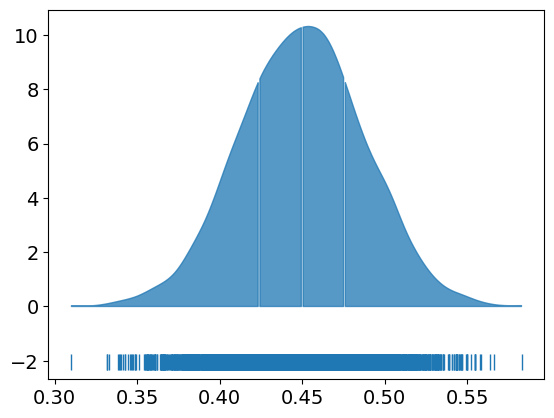

In [43]:
az.plot_dist(fit2['alpha'], rug=True, quantiles=[.25, .5, .75])

<Axes: >

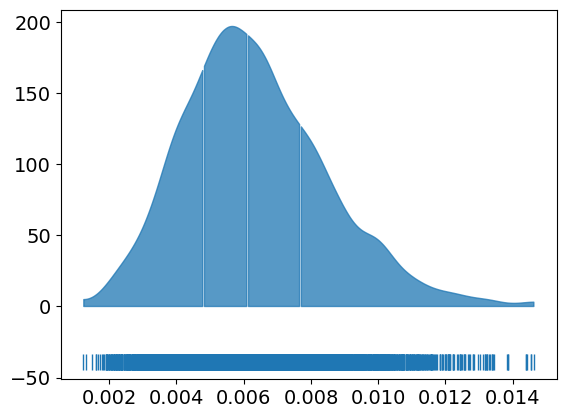

In [44]:
az.plot_dist(fit2['beta_preg'], rug=True, quantiles=[.25, .5, .75])

<Axes: >

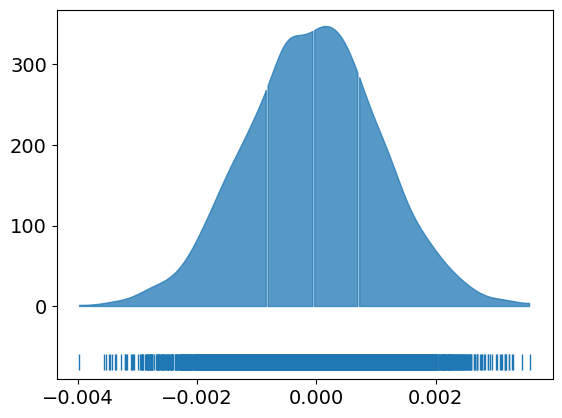

In [45]:
az.plot_dist(fit2['beta_age'], rug=True, quantiles=[.25, .5, .75])

<Axes: >

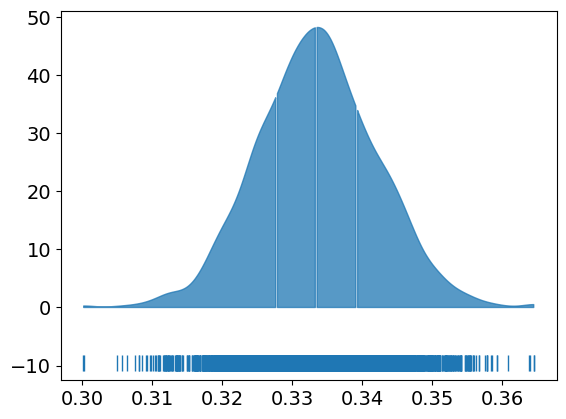

In [46]:
az.plot_dist(fit2['sigma'], rug=True, quantiles=[.25, .5, .75])

In [47]:
summary2 = az.summary(fit2) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [48]:
summary2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.450,0.037,0.381,0.519,0.001,0.001,1294.0,1384.0,1.0
beta_preg,0.006,0.002,0.003,0.010,0.000,0.000,3045.0,1958.0,1.0
beta_age,-0.000,0.001,-0.002,0.002,0.000,0.000,1412.0,1844.0,1.0
sigma,0.333,0.009,0.319,0.350,0.000,0.000,1664.0,1709.0,1.0
y_rep[0],0.487,0.332,-0.124,1.104,0.005,0.004,4142.0,3746.0,1.0
...,...,...,...,...,...,...,...,...,...
y_rep[763],0.517,0.331,-0.151,1.105,0.005,0.004,4036.0,3776.0,1.0
y_rep[764],0.460,0.337,-0.160,1.123,0.006,0.004,3734.0,3301.0,1.0
y_rep[765],0.487,0.333,-0.188,1.077,0.005,0.004,4084.0,3812.0,1.0
y_rep[766],0.457,0.337,-0.185,1.078,0.005,0.004,3830.0,3725.0,1.0


<Axes: >

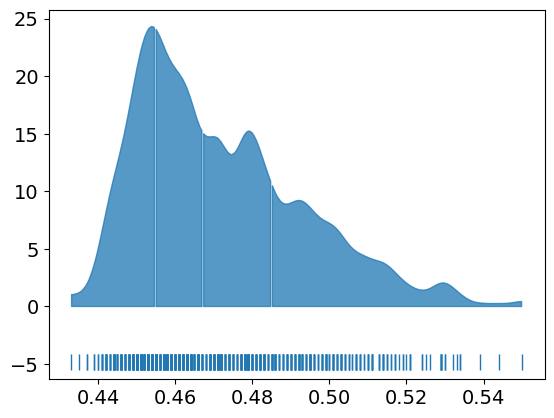

In [49]:
az.plot_dist(summary2['mean'][5:], rug=True, quantiles=[.25, .5, .75])

In [50]:
stan_data_simu_v2 = az.from_pystan(
    posterior=fit2,
    posterior_predictive=["y_rep"],
    observed_data=["y"],
    posterior_model=stan_model_v2,
    coords={"y_hat": np.arange(data["N"])},
)

<Axes: xlabel='y / y_rep'>

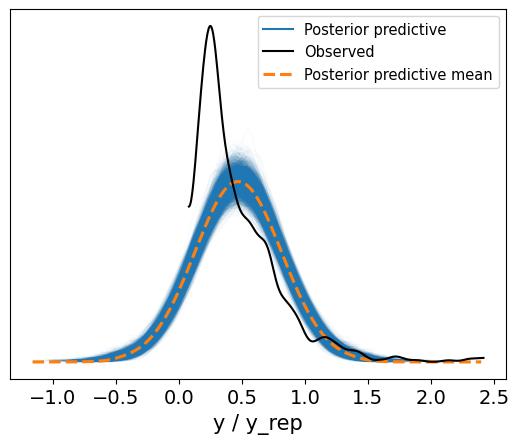

In [51]:
az.plot_ppc(stan_data_simu_v2, data_pairs={"y": "y_rep"}, alpha=0.03, textsize=14)

### third iteration

apply log_normal to beta_age parameter distribution

In [52]:
stan_code_v3 = """

data {
int<lower=0> N;
vector[N] y;
vector[N] pregnancies;
vector[N] ages;
}

parameters {
real alpha;
real beta_preg;
real beta_age;
real <lower=0> sigma;
}

model {
//prior 
alpha ~ normal(0.46,1);
beta_preg ~ lognormal(0,1);
beta_age~ lognormal(0,1);
sigma ~ cauchy(0,5);

//model
y ~ normal(pregnancies * beta_preg + ages * beta_age + alpha, sigma);
}

generated quantities {
//predictive posterior check

vector[N] y_rep;

for(n in 1:N){

y_rep[n] = normal_rng(pregnancies[n] * beta_preg + ages[n] * beta_age + alpha, sigma);

}
}
"""

In [53]:
stan_model_v3 = stan.build(stan_code_v3, data=data)

Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/4hq44vic/model_4hq44vic.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-pac

Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/4hq44vic/model_4hq44vic.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 4.0s
Building: 4.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/4hq44vic/model_4hq44vic.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/4hq44vic/model_4hq44vic.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:12:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp:468:7: warning: unused variable 'kdiv' [-Wunused-variable]
  int kdiv = kdivide;
      ^


Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/4hq44vic/model_4hq44vic.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:15:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-

Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 7.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/4hq44vic/model_4hq44vic.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused variable 'n' [-Wunused-variable]
  int n = G.rows();  // number of states
      ^


Building: 7.4s
Building: 7.5s
Building: 7.6s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/4hq44vic/model_4hq44vic.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan

Building: 7.7s
Building: 7.8s
Building: 7.9s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/4hq44vic/model_4hq44vic.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan

Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/4hq44vic/model_4hq44vic.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s


/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/4hq44vic/model_4hq44vic.cpp:2:
In file i

Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/4hq44vic/model_4hq44vic.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:100:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                                ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/h

Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s


21 warnings generated.
ld: warning: ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_cvodes.a(cvodea.o)) was built for newer macOS version (11.0) than being linked (10.9)
object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_idas.a(idaa.o)) was built for newer macOS version (11.0) than being linked (10.9)ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)

ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being

In [55]:
fit3 = stan_model_v3.sample(num_chains=4, num_samples=1000, num_warmup=500) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   2% (101/6000)
Sampling:   3% (201/6000)
Sampling:   8% (501/6000)
Sampling:  12% (700/6000)
Sampling:  18% (1101/6000)
Sampling:  42% (2501/6000)
Sampling:  45% (2702/6000)
Sampling:  67% (4002/6000)
Sampling:  68% (4101/6000)
Sampling:  70% (4200/6000)
Sampling:  72% (4300/6000)
Sampling:  73% (4400/6000)
Sampling:  75% (4500/6000)
Sampling:  77% (4600/6000)
Sampling:  78% (4700/6000)
Sampling:  80% (4800/6000)
Sampling:  82% (4900/6000)
Sampling:  83% (5000/6000)
Sampling:  85% (5100/6000)
Sampling:  87% (5200/6000)
Sampling:  88% (5300/6000)
Sampling:  90% (5400/6000)
Sampling:  92% (5500/6000)
Sampling:  93% (5600/6000)
Sampling:  95% (5700/6000)
Sampling:  97% (5800/6000)
Sampling:  98% (5900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: lognormal_lpdf: Random variable is -0

In [56]:
fit3.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_preg,beta_age,...,y_rep.759,y_rep.760,y_rep.761,y_rep.762,y_rep.763,y_rep.764,y_rep.765,y_rep.766,y_rep.767,y_rep.768
draws,,,,,,,,,,,,,,,,,,,,,
0,435.601750,0.912350,0.071530,5.0,39.0,0.0,-433.736472,0.359967,0.004086,0.002452,...,0.756115,1.119521,0.787524,0.555937,0.342657,0.788368,0.375741,0.155124,0.216296,0.855070
1,-4901.432604,0.983332,0.001140,3.0,7.0,0.0,4911.863901,1.232565,0.019125,0.000016,...,1.154093,1.349864,1.278883,1.774706,1.404067,1.590179,1.848403,1.068040,1.302761,1.490650
2,433.090948,0.969422,0.058622,5.0,63.0,0.0,-431.838678,0.399612,0.002173,0.001994,...,0.805719,0.437743,0.148320,0.690266,0.562080,0.345811,0.483740,0.830261,0.627818,0.215154
3,81.125638,0.391446,0.014985,3.0,7.0,0.0,-80.260404,-0.799966,0.008593,0.034032,...,-0.138352,1.777304,0.287052,1.575946,1.197875,1.975304,0.209696,0.300644,1.285325,-0.186062
4,436.115808,0.995940,0.071530,5.0,39.0,0.0,-435.298430,0.386708,0.003618,0.002145,...,0.758671,0.906466,0.827604,0.628041,0.249284,0.333680,0.636617,0.294288,0.744535,0.494523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,436.154957,0.999758,0.014985,9.0,739.0,0.0,-435.471547,0.381536,0.004967,0.002163,...,0.500933,0.099042,0.465296,0.415551,1.301932,1.135820,0.240877,0.230423,0.463916,0.654723
3996,435.010176,0.998842,0.071530,4.0,23.0,0.0,-433.610173,0.371095,0.007381,0.002136,...,0.370737,0.683613,0.747466,0.511109,0.931290,0.850747,0.480256,0.583460,0.615467,0.968189
3997,432.525560,0.999922,0.001140,7.0,255.0,0.0,-428.468426,0.394267,0.009630,0.001282,...,1.005165,0.667009,0.215223,0.740686,0.414556,0.605122,0.856419,0.396481,0.244184,0.729644


In [57]:
summary3 = az.summary(fit3) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [58]:
summary3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.395,0.206,0.179,1.042,0.071,0.052,9.0,11.0,1.34
beta_preg,0.005,0.002,0.000,0.008,0.000,0.000,23.0,12.0,1.12
beta_age,0.003,0.003,0.000,0.004,0.001,0.001,10.0,11.0,1.31
sigma,0.334,0.025,0.273,0.364,0.006,0.004,43.0,12.0,1.06
y_rep[0],0.555,0.369,-0.174,1.226,0.038,0.036,101.0,56.0,1.03
...,...,...,...,...,...,...,...,...,...
y_rep[763],0.627,0.364,-0.039,1.320,0.034,0.031,126.0,156.0,1.02
y_rep[764],0.475,0.372,-0.212,1.207,0.058,0.052,46.0,29.0,1.06
y_rep[765],0.492,0.362,-0.177,1.189,0.046,0.042,66.0,48.0,1.04
y_rep[766],0.530,0.360,-0.155,1.201,0.045,0.040,67.0,58.0,1.04


<Axes: >

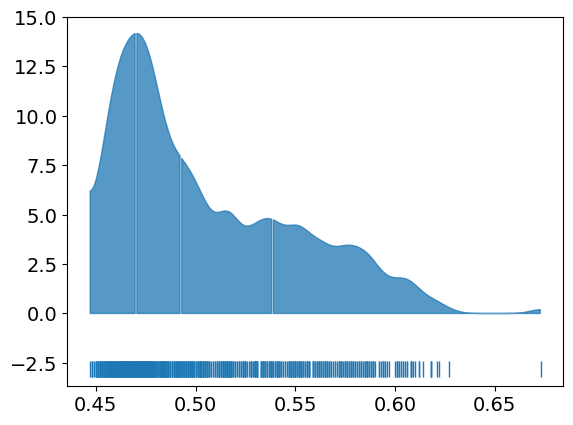

In [69]:
az.plot_dist(summary3['mean'][5:], rug=True, quantiles=[.25, .5, .75])

<Axes: >

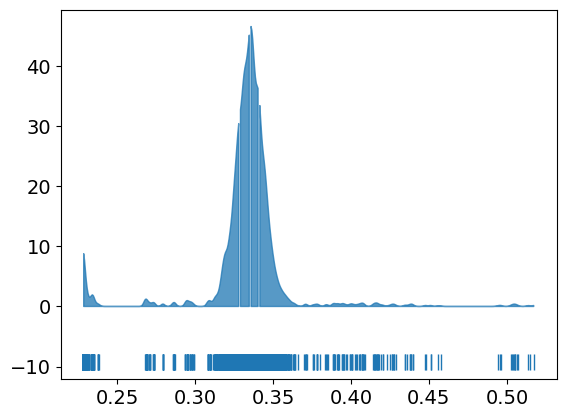

In [70]:
az.plot_dist(fit3['sigma'], rug=True, quantiles=[.25, .5, .75])

<Axes: >

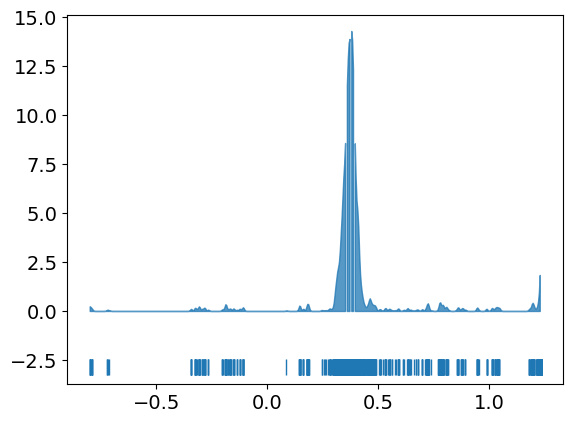

In [98]:
az.plot_dist(fit3['alpha'], rug=True, quantiles=[.25, .5, .75])

<Axes: >

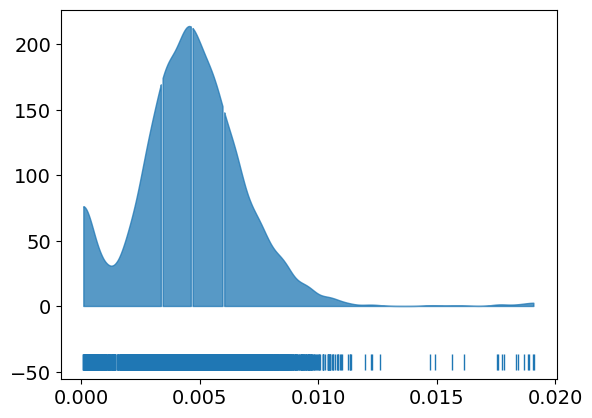

In [97]:
az.plot_dist(fit3['beta_preg'], rug=True, quantiles=[.25, .5, .75])

<Axes: >

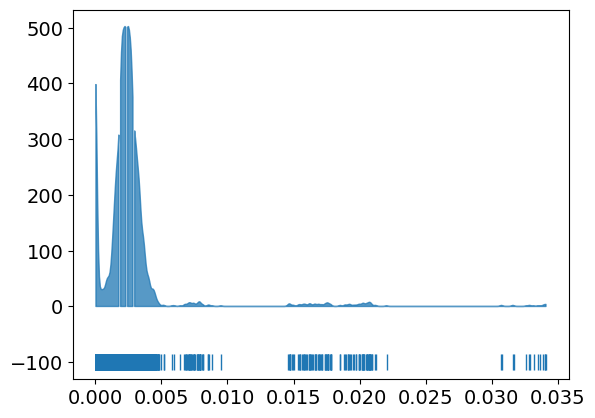

In [96]:
az.plot_dist(fit3['beta_age'], rug=True, quantiles=[.25, .5, .75])

In [61]:
stan_data_simu_v3 = az.from_pystan(
    posterior=fit3,
    posterior_predictive=["y_rep"],
    observed_data=["y"],
    posterior_model=stan_model_v3,
    coords={"y_hat": np.arange(data["N"])},
)

In [62]:
stan_data_simu_v3

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y / y_rep'>

/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


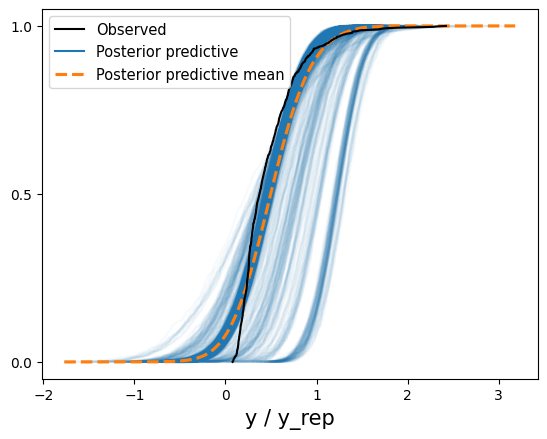

In [104]:
az.plot_ppc(stan_data_simu_v3, data_pairs={"y": "y_rep"}, kind="cumulative", alpha=0.03, textsize=14)

### 4th iteration

apply gamma distribution to y because the predictive prior check shows skewed.

In [37]:
stan_code_v4 = """

data {
int<lower=0> N;
vector[N] y;
vector[N] pregnancies;
vector[N] ages;
}

parameters {
real alpha;
real<lower=0> beta;
real beta_preg;
real beta_age;
}

model {
//prior 
alpha ~ normal(2, 0.5);
beta_preg ~ lognormal(0,1);
beta_age~ normal(0,1);

//model
y ~ gamma(alpha, beta / (pregnancies * beta_preg + ages * beta_age));
}

generated quantities {
//predictive posterior check

vector[N] y_rep;

for(n in 1:N){

y_rep[n] = gamma_rng(alpha, beta / (pregnancies[n] * beta_preg + ages[n] * beta_age));

}
}
"""

In [34]:
## train

train_data = {
"N": len(train), 
"pregnancies": train.loc[:, "Pregnancies"].values,
"ages": train.loc[:, "Age"].values,
 "y": train.loc[:, "DiabetesPedigreeFunction"].values,   
}

In [35]:
## test


test_data = {
"N": len(test), 
"pregnancies": test.loc[:, "Pregnancies"].values,
"ages": test.loc[:, "Age"].values,
 "y": test.loc[:, "DiabetesPedigreeFunction"].values,   
}

In [38]:
stan_model_v4 = stan.build(stan_code_v4, data=train_data)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/hsb7cf43/model_hsb7cf43.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-pac

Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/hsb7cf43/model_hsb7cf43.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/hsb7cf43/model_hsb7cf43.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/hsb7cf43/model_hsb7cf43.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:12:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp:468:7: warning: unused variable 'kdiv' [-Wunused-variable]
  int kdiv = kdivide;
      ^


Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/hsb7cf43/model_hsb7cf43.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:15:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-

Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.8s
Building: 5.9s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/hsb7cf43/model_hsb7cf43.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused variable 'n' [-Wunused-variable]
  int n = G.rows();  // number of states
      ^


Building: 6.0s
Building: 6.1s
Building: 6.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/hsb7cf43/model_hsb7cf43.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan

Building: 6.3s
Building: 6.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/hsb7cf43/model_hsb7cf43.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan

Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 7.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/hsb7cf43/model_hsb7cf43.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 7.2s
Building: 7.3s
Building: 7.4s
Building: 7.5s


/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/hsb7cf43/model_hsb7cf43.cpp:2:
In file i

Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/hsb7cf43/model_hsb7cf43.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:100:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                                ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/h

Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s


21 warnings generated.
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: ob

In [39]:
fit4 = stan_model_v4.sample(num_chains=4, num_samples=1000, num_warmup=500) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   7% (400/6000)
Sampling:  10% (600/6000)
Sampling:  35% (2100/6000)
Sampling:  58% (3500/6000)
Sampling:  78% (4700/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: lognormal_lpdf: Random variable is -1.65287, but must be nonnegative! (in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_sj1vxvy9/model_hsb7cf43.stan', line 20, column 0 to column 27)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Inverse scale parameter[1] is -0.030766, but must be positive finite! (in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_sj1vxvy9/model_hsb7cf43.stan', line 24, column 0 to column 69)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: lognormal_lpdf: R

In [40]:
fit4.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,beta_preg,...,y_rep.375,y_rep.376,y_rep.377,y_rep.378,y_rep.379,y_rep.380,y_rep.381,y_rep.382,y_rep.383,y_rep.384
draws,,,,,,,,,,,,,,,,,,,,,
0,-44.301091,0.981655,0.069450,6.0,63.0,0.0,44.750064,2.248757,396.629436,0.584317,...,0.651366,0.299990,0.285654,0.229508,0.619166,0.502323,0.086010,0.323206,0.122270,0.407359
1,-43.564411,0.755946,0.059699,3.0,15.0,0.0,44.478624,2.336224,165.448577,0.262235,...,0.116408,0.599456,0.266728,0.820890,0.212633,0.166752,0.693359,0.087485,0.170769,0.721345
2,-42.613089,0.984432,0.072705,5.0,63.0,0.0,44.798351,2.259774,275.648582,0.365289,...,0.602271,1.029098,0.912154,0.555149,0.293456,0.439797,0.241729,0.790594,0.154566,1.594826
3,-43.449224,0.998897,0.061775,6.0,63.0,0.0,43.991187,1.953359,205.347490,0.317608,...,0.526144,0.239859,0.701336,0.283884,0.481879,0.438595,0.108406,0.526227,0.061642,0.519077
4,-44.791852,0.977008,0.069450,6.0,63.0,0.0,45.584613,2.214621,349.748709,0.732041,...,0.039545,0.728262,1.812746,0.430449,0.424996,0.286067,0.215757,1.443083,0.415328,0.648799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-46.111815,0.969931,0.061775,5.0,31.0,0.0,46.624587,1.935407,398.021220,0.334244,...,0.541278,0.333848,0.463182,0.114754,0.383517,0.068561,0.359448,0.684952,0.311929,0.303988
3996,-44.948770,0.804899,0.069450,3.0,11.0,0.0,48.271654,2.112785,424.878377,0.171964,...,0.223272,0.690908,0.654920,0.693217,0.612904,0.167309,0.120925,0.109341,0.147735,0.597950
3997,-42.563547,0.997311,0.059699,5.0,63.0,0.0,45.253576,2.092499,213.706508,0.054287,...,0.497383,1.204019,0.036141,0.540715,1.232648,0.302127,0.244327,0.110901,0.532701,0.531677


In [41]:
summary4 = az.summary(fit4) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [42]:
summary4

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.190,0.138,1.934,2.464,0.003,0.002,1588.0,1614.0,1.0
beta,254.939,96.516,83.699,425.815,3.322,2.350,784.0,591.0,1.0
beta_preg,0.271,0.184,0.024,0.605,0.007,0.005,1040.0,1013.0,1.0
beta_age,1.770,0.655,0.591,2.882,0.022,0.016,802.0,625.0,1.0
y_rep[0],0.656,0.447,0.029,1.474,0.007,0.005,3895.0,4001.0,1.0
...,...,...,...,...,...,...,...,...,...
y_rep[379],0.392,0.264,0.016,0.869,0.004,0.003,3832.0,3856.0,1.0
y_rep[380],0.367,0.248,0.015,0.812,0.004,0.003,3952.0,3930.0,1.0
y_rep[381],0.536,0.362,0.022,1.182,0.006,0.004,3856.0,3772.0,1.0
y_rep[382],0.353,0.241,0.012,0.777,0.004,0.003,3907.0,3828.0,1.0


<Axes: >

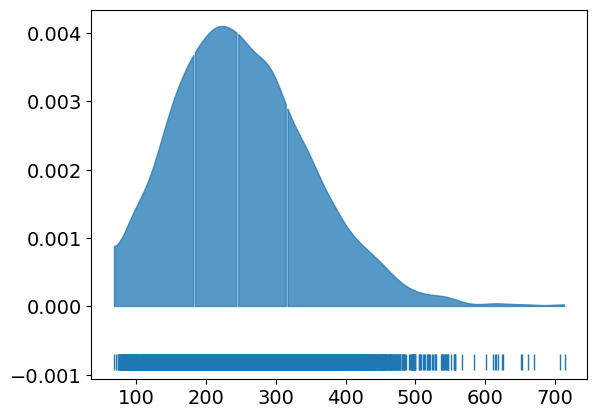

In [43]:
az.plot_dist(fit4['beta'], rug=True, quantiles=[.25, .5, .75])

<Axes: >

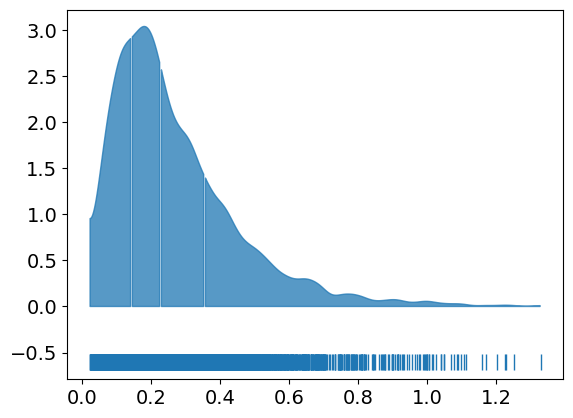

In [44]:
az.plot_dist(fit4['beta_preg'], rug=True, quantiles=[.25, .5, .75])

<Axes: >

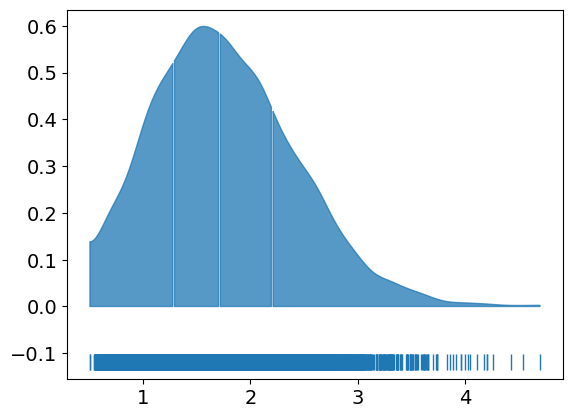

In [45]:
az.plot_dist(fit4['beta_age'], rug=True, quantiles=[.25, .5, .75])

<Axes: >

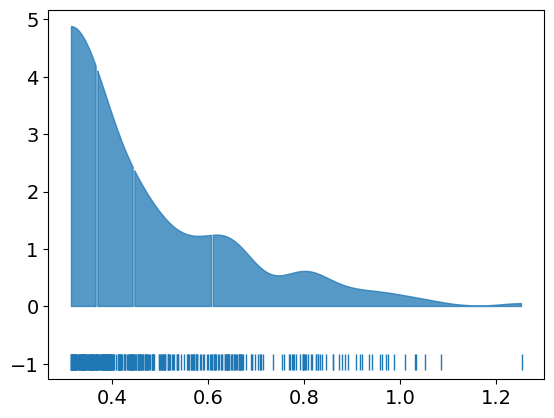

In [47]:
az.plot_dist(summary4['mean'][5:], rug=True, quantiles=[.25, .5, .75])

In [50]:
stan_data_simu_v4 = az.from_pystan(
    posterior=fit4,
    posterior_predictive=["y_rep"],
    observed_data=["y"],
    posterior_model=stan_model_v4,
    coords={"y_hat": np.arange(train_data["N"])},
)

<Axes: xlabel='y / y_rep'>

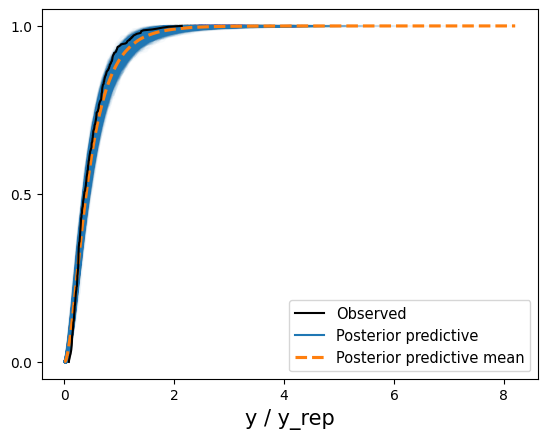

In [51]:
az.plot_ppc(stan_data_simu_v4, data_pairs={"y": "y_rep"}, kind="cumulative", alpha=0.03, textsize=14)

In [52]:
stan_model_v4_test = stan.build(stan_code_v4, data=test_data)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_e70t_qfl/model_hsb7cf43.stan', line 24, column 10: A
    gamma distribution is given parameter alpha as a shape parameter
    (argument 1), but alpha was not constrained to be strictly positive.
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_e70t_qfl/model_hsb7cf43.stan', line 20, column 0: Parameter
    beta_preg is given a lognormal distribution, which has strictly positive
    support, but beta_preg was not constrained to be strictly positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [53]:
fit_test = stan_model_v4.fixed_param(num_chains=4, num_samples=1000) 

Sampling:   0%
Sampling:  25% (1000/4000)
Sampling:  50% (2000/4000)
Sampling:  75% (3000/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: lognormal_lpdf: Random variable is -1.65287, but must be nonnegative! (in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_sj1vxvy9/model_hsb7cf43.stan', line 20, column 0 to column 27)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Inverse scale parameter[1] is -0.030766, but must be positive finite! (in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_sj1vxvy9/model_hsb7cf43.stan', line 24, column 0 to column 69)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: lognormal_lpdf: Random variable is -1.38614, but must be nonnegative! (in '/var/folders/37/wj6j

In [60]:
stan_data_simu_v4 = az.from_pystan(
    posterior=fit_test,
    posterior_predictive=["y_rep"],
    observed_data=["y"],
    posterior_model=stan_model_v4,
    coords={"y_hat": np.arange(test_data["N"])},
)

<Axes: xlabel='y / y_rep'>

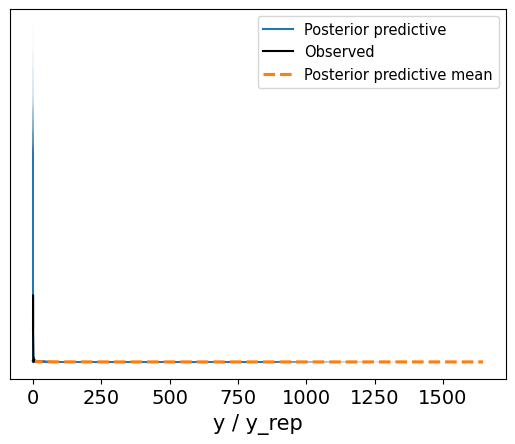

In [59]:
az.plot_ppc(stan_data_simu_v4, data_pairs={"y": "y_rep"}, alpha=0.03, textsize=14)

Fake data

In [105]:
from faker import Faker # library for generating random num

faker = Faker()
Faker.seed(1000)

# Generate fake data
data_simu = {
    'Pregnancies': [faker.random_int(min=0, max=17) for _ in range(3000)],
    'Glucose': [faker.random_int(min=0, max=200) for _ in range(3000)],
    'BloodPressure': [faker.random_int(min=0, max=100) for _ in range(3000)],
    'SkinTickness': [faker.random_int(min=0, max=100) for _ in range(3000)],
    'Insulin': [faker.random_int() for _ in range(3000)],
    'BMI': [faker.random.uniform(a=0, b=67) for _ in range(3000)],
    'DiabetesPedigreeFunction': [faker.random.uniform(a=0, b=3) for _ in range(3000)],
    'Age': [faker.random_int(min=1, max=100) for _ in range(3000)],
    'Outcome': [faker.random_int(min=0, max=1) for _ in range(3000)]
}


# Create a DataFrame
df_simu = pd.DataFrame(data_simu)

# Display the DataFrame
df_simu.head()

,Pregnancies,Glucose,BloodPressure,SkinTickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,13,59,24,99,6861,40.375093,1.122980,90,1
1,3,198,62,54,7416,60.019936,1.164683,84,1
2,12,89,42,80,7606,29.901838,0.776493,50,0
3,11,169,66,73,9796,18.782294,2.959806,82,1
4,2,24,60,76,247,13.799934,1.003071,90,0


In [107]:
data_fake = {
"N": len(df_simu), 
"pregnancies": df_simu.loc[:, "Pregnancies"].values,
"y": df_simu.loc[:, "DiabetesPedigreeFunction"].values,
"ages": df_simu.loc[:, "Age"].values,
}

In [123]:
stan_model_v4 = stan.build(stan_code_v4, data=data_fake)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_6p6prhus/model_hsb7cf43.stan', line 24, column 10: A
    gamma distribution is given parameter alpha as a shape parameter
    (argument 1), but alpha was not constrained to be strictly positive.
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_6p6prhus/model_hsb7cf43.stan', line 20, column 0: Parameter
    beta_preg is given a lognormal distribution, which has strictly positive
    support, but beta_preg was not constrained to be strictly positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [125]:
fit_fake = stan_model_v4.fixed_param(num_chains=4, num_samples=1000) 

Sampling:   0%
Sampling:  25% (1000/4000)
Sampling:  50% (2000/4000)
Sampling:  75% (3000/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: lognormal_lpdf: Random variable is -0.553671, but must be nonnegative! (in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_tt5n9vzs/model_hsb7cf43.stan', line 20, column 0 to column 27)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Inverse scale parameter[1] is -0.00956625, but must be positive finite! (in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_tt5n9vzs/model_hsb7cf43.stan', line 24, column 0 to column 69)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Shape parameter is -0.850549, but must be positive finite! (in '/var/folders/37/

In [126]:
stan_data_simu_v4 = az.from_pystan(
    posterior=fit_fake,
    posterior_predictive=["y_rep"],
    observed_data=["y"],
    posterior_model=stan_model_v4,
    coords={"y_hat": np.arange(data["N"])},
)

<Axes: xlabel='y / y_rep'>

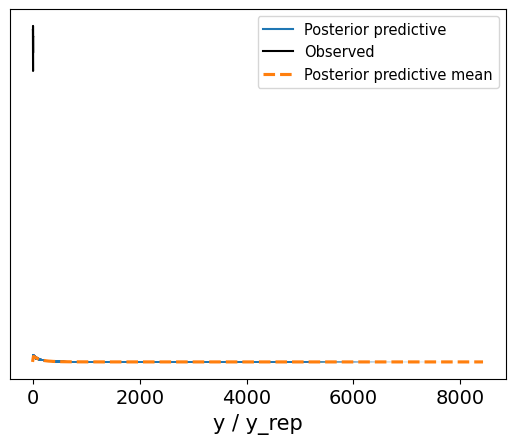

In [128]:
az.plot_ppc(stan_data_simu_v4, data_pairs={"y": "y_rep"}, alpha=0.03, textsize=14)

In [16]:
# import the relevant modules
import shutil
import httpstan.models
import httpstan.cache

In [27]:
httpstan.cache.list_model_names()

[]

In [26]:
httpstan.cache.delete_model_directory('models/4hq44vic') ## add the model pointer you want to remove